In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
# | default_exp npg.plots


In [ ]:
# | export

import pandas as pd
import pyarrow.dataset as ds
import seaborn as sns
from fastcore.all import *


In [ ]:
# | eval: false
cols = "circuit	description	timestamp	value".split()

keep_descriptions = ["active power (kw)", "reactive power (kvar)"]

scanner_args = dict(
    filter=ds.field("description").isin(keep_descriptions),
    columns=cols,
)
dset = ds.dataset(
    "npg.parquet/",
    partitioning="hive",
)

dset.count_rows(**scanner_args)


43107636

In [ ]:
# | eval: false
df = (
    dset.to_table(**scanner_args)
    .to_pandas(self_destruct=True)
    .set_index(["circuit", "timestamp", "description"], append=False)
)
df


value
circuit                       timestamp                 description                 
LINTON - TRX1                 2022-01-01 00:00:00+00:00 active power (kw)        0.0
                              2022-01-01 00:30:00+00:00 active power (kw)        0.0
                              2022-01-01 01:00:00+00:00 active power (kw)        0.0
                              2022-01-01 01:30:00+00:00 active power (kw)        0.0
                              2022-01-01 02:00:00+00:00 active power (kw)        0.0
...                                                                              ...
WAVERLEY BUSINESS PARK - TRX2 2022-12-31 21:30:00+00:00 reactive power (kvar) -220.0
                              2022-12-31 22:00:00+00:00 reactive power (kvar) -283.0
                              2022-12-31 22:30:00+00:00 reactive power (kvar) -314.0
                              2022-12-31 23:00:00+00:00 reactive power (kvar) -314.0
                              2022-12-31 23:30:00+00:00 reactive power (kvar) -314.0

[43107636 rows x 1 columns]

In [ ]:
# | eval: false
df.loc[df.index.duplicated()]


value
circuit       timestamp                 description                   
LINTON - TRX1 2022-01-01 00:00:00+00:00 active power (kw)       3600.0
              2022-01-01 00:30:00+00:00 active power (kw)       8100.0
              2022-01-01 01:00:00+00:00 active power (kw)      10800.0
              2022-01-01 01:30:00+00:00 active power (kw)      13500.0
              2022-01-01 02:00:00+00:00 active power (kw)        900.0
...                                                                ...
BARUGH - TRX2 2022-12-31 21:30:00+00:00 reactive power (kvar)   -769.0
              2022-12-31 22:00:00+00:00 reactive power (kvar)   -769.0
              2022-12-31 22:30:00+00:00 reactive power (kvar)   -895.0
              2022-12-31 23:00:00+00:00 reactive power (kvar)   -895.0
              2022-12-31 23:30:00+00:00 reactive power (kvar)   -911.0

[1205943 rows x 1 columns]

In [ ]:
# | eval: false

df.loc[df.value.isna()]


,,,value
circuit,timestamp,description,


In [ ]:
# | eval: false

# df = df.loc[~df.index.duplicated()]
df


value
circuit                       timestamp                 description                 
LINTON - TRX1                 2022-01-01 00:00:00+00:00 active power (kw)        0.0
                              2022-01-01 00:30:00+00:00 active power (kw)        0.0
                              2022-01-01 01:00:00+00:00 active power (kw)        0.0
                              2022-01-01 01:30:00+00:00 active power (kw)        0.0
                              2022-01-01 02:00:00+00:00 active power (kw)        0.0
...                                                                              ...
WAVERLEY BUSINESS PARK - TRX2 2022-12-31 21:30:00+00:00 reactive power (kvar) -220.0
                              2022-12-31 22:00:00+00:00 reactive power (kvar) -283.0
                              2022-12-31 22:30:00+00:00 reactive power (kvar) -314.0
                              2022-12-31 23:00:00+00:00 reactive power (kvar) -314.0
                              2022-12-31 23:30:00+00:00 reactive power (kvar) -314.0

[43107636 rows x 1 columns]

In [ ]:
def show_in_time(df, key=None, apply_func=len):
    if not isinstance(key, list):
        key = [] if key is None else [key]
    return df.groupby(key + [pd.Grouper(freq="M", level="timestamp")]).apply(apply_func)


<Axes: xlabel='timestamp'>

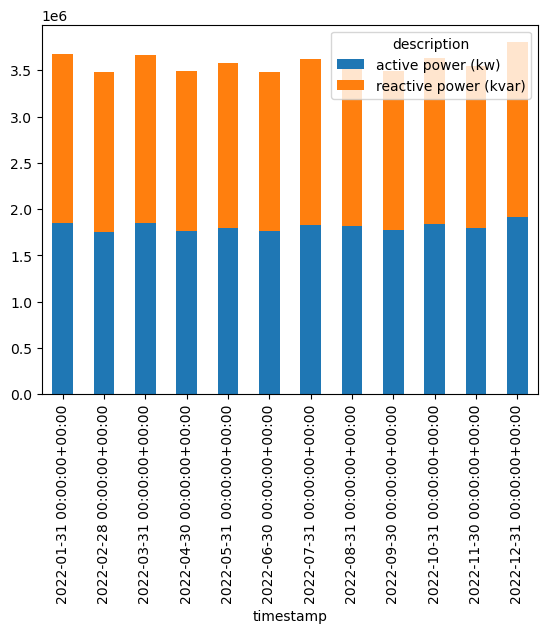

In [ ]:
# | eval: false
df.pipe(show_in_time, "description").unstack(0).plot(kind="bar", stacked=True)


<Axes: xlabel='timestamp'>

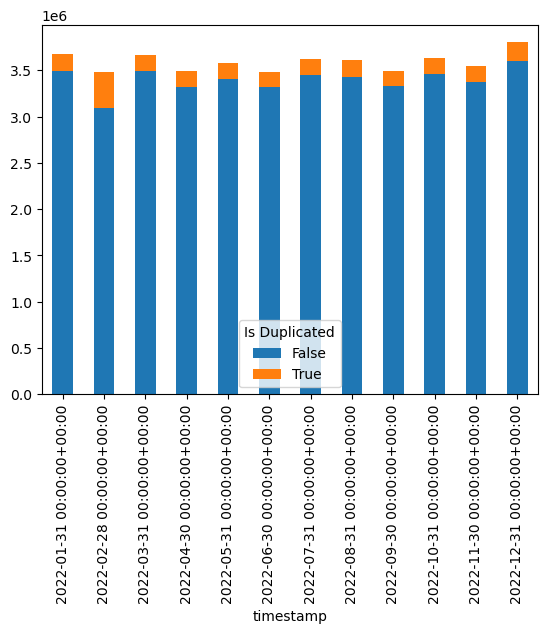

In [ ]:
# | eval: false
df.assign(**{"Is Duplicated": df.index.duplicated(False)}).pipe(
    show_in_time, "Is Duplicated"
).unstack(0).plot(kind="bar", stacked=True)


In [ ]:
# | eval: false

df = df.loc[~df.index.duplicated(False)]
df

value
circuit                       timestamp                 description                   
LINTON - BEDLINGTON SW TEED   2022-01-01 00:00:00+00:00 active power (kw)       7000.0
                              2022-01-01 00:30:00+00:00 active power (kw)       4500.0
                              2022-01-01 01:00:00+00:00 active power (kw)       6500.0
                              2022-01-01 01:30:00+00:00 active power (kw)      11000.0
                              2022-01-01 02:00:00+00:00 active power (kw)       5500.0
...                                                                                ...
WAVERLEY BUSINESS PARK - TRX2 2022-12-31 21:30:00+00:00 reactive power (kvar)   -220.0
                              2022-12-31 22:00:00+00:00 reactive power (kvar)   -283.0
                              2022-12-31 22:30:00+00:00 reactive power (kvar)   -314.0
                              2022-12-31 23:00:00+00:00 reactive power (kvar)   -314.0
                              2022-12-31 23:30:00+00:00 reactive power (kvar)   -314.0

[40781170 rows x 1 columns]

<Axes: xlabel='d2', ylabel='timestamp'>

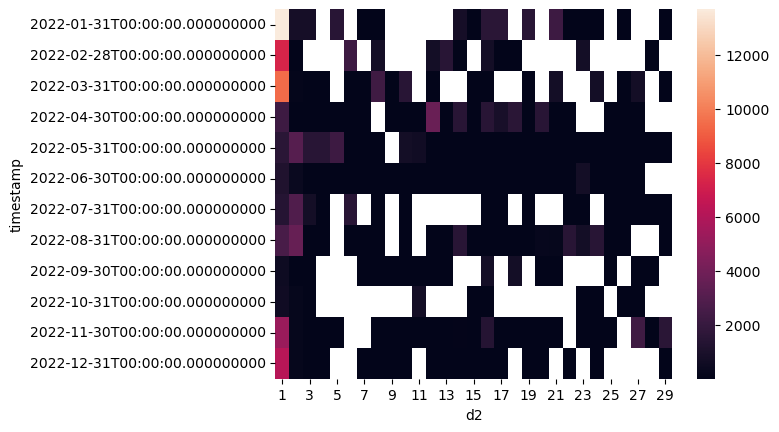

In [ ]:
# | eval: false

sns.heatmap(
    data=df.assign(
        d2=(
            df.index.get_level_values(1).to_frame(index=False).timestamp.dt.minute % 30
        ).values
    )[["d2"]]
    .pipe(show_in_time, apply_func=pd.DataFrame.value_counts)
    .unstack(-1)
    .iloc(axis=1)[1:]
)


In [ ]:
# | eval:false
df = df.groupby(['circuit', pd.Grouper(level=1, freq='30T'), 'description']).first().dropna()
df

value
circuit                                  timestamp                 description                  
ABBEY ROAD - TRX1                        2022-01-01 00:00:00+00:00 active power (kw)      2040.0
                                                                   reactive power (kvar)     0.0
                                         2022-01-01 00:30:00+00:00 active power (kw)      2000.0
                                                                   reactive power (kvar)     0.0
                                         2022-01-01 01:00:00+00:00 active power (kw)      2240.0
...                                                                                          ...
YORK UNIVERSITY - HESLINGTON CAMPUS SW 2 2022-12-15 22:00:00+00:00 reactive power (kvar)    30.0
                                         2022-12-15 22:30:00+00:00 reactive power (kvar)    30.0
                                         2022-12-15 23:00:00+00:00 reactive power (kvar)    30.0
                                         2022-12-15 23:30:00+00:00 reactive power (kvar)    30.0
                                         2022-12-16 00:00:00+00:00 reactive power (kvar)    30.0

[40709562 rows x 1 columns]

In [ ]:
# | eval: false
(df.index.get_level_values('timestamp').to_frame().timestamp.dt.minute % 30).value_counts()

0    40709562
Name: timestamp, dtype: int64

In [ ]:
# | eval: false

df = df.unstack([-1, 0]).droplevel(0, axis=1).sort_index(axis=1)
df


description               active power (kw)                                  \
circuit                   ABBEY ROAD - TRX1 ABBEY ROAD - TRX2 ACKLAM - TRX1   
timestamp                                                                     
2022-01-01 00:00:00+00:00            2040.0            2070.0        4560.0   
2022-01-01 00:30:00+00:00            2000.0            2110.0        4560.0   
2022-01-01 01:00:00+00:00            2240.0            2320.0        4320.0   
2022-01-01 01:30:00+00:00            2210.0            2290.0        4080.0   
2022-01-01 02:00:00+00:00            2130.0            2180.0        3840.0   
...                                     ...               ...           ...   
2022-12-31 21:30:00+00:00            2420.0            2490.0        5280.0   
2022-12-31 22:00:00+00:00            2320.0            2400.0        5040.0   
2022-12-31 22:30:00+00:00            2240.0            2250.0        4800.0   
2022-12-31 23:00:00+00:00            2110.0            2210.0        4560.0   
2022-12-31 23:30:00+00:00            2070.0            2100.0        4320.0   

description                                                   \
circuit                   ACKLAM - TRX2 AIREDALE ROAD - TRX1   
timestamp                                                      
2022-01-01 00:00:00+00:00        4560.0               1790.0   
2022-01-01 00:30:00+00:00        4320.0               1720.0   
2022-01-01 01:00:00+00:00        4320.0               1700.0   
2022-01-01 01:30:00+00:00        4080.0               1650.0   
2022-01-01 02:00:00+00:00        3840.0               1620.0   
...                                 ...                  ...   
2022-12-31 21:30:00+00:00        5280.0               1860.0   
2022-12-31 22:00:00+00:00        5040.0               1760.0   
2022-12-31 22:30:00+00:00        4800.0               1710.0   
2022-12-31 23:00:00+00:00        4560.0               1650.0   
2022-12-31 23:30:00+00:00        4320.0               1600.0   

description                                                                 \
circuit                   AIREDALE ROAD - TRX2 ALDHAM - TRX1 ALDHAM - TRX2   
timestamp                                                                    
2022-01-01 00:00:00+00:00               1920.0        3580.0        3769.0   
2022-01-01 00:30:00+00:00               1880.0        3350.0        3559.0   
2022-01-01 01:00:00+00:00               1800.0        3329.0        3538.0   
2022-01-01 01:30:00+00:00               1770.0        3120.0        3329.0   
2022-01-01 02:00:00+00:00               1730.0        3099.0        3308.0   
...                                        ...           ...           ...   
2022-12-31 21:30:00+00:00               2340.0        3873.0        3873.0   
2022-12-31 22:00:00+00:00               2190.0        3517.0        3517.0   
2022-12-31 22:30:00+00:00               2140.0        3517.0        3517.0   
2022-12-31 23:00:00+00:00               2080.0        3517.0        3517.0   
2022-12-31 23:30:00+00:00               1930.0        3141.0        3141.0   

description                                            \
circuit                   ALFRED GELDER STREET - TRX1   
timestamp                                               
2022-01-01 00:00:00+00:00                      2806.0   
2022-01-01 00:30:00+00:00                      2876.0   
2022-01-01 01:00:00+00:00                      3169.0   
2022-01-01 01:30:00+00:00                      3099.0   
2022-01-01 02:00:00+00:00                      3036.0   
...                                               ...   
2022-12-31 21:30:00+00:00                      3090.0   
2022-12-31 22:00:00+00:00                      3000.0   
2022-12-31 22:30:00+00:00                      2940.0   
2022-12-31 23:00:00+00:00                      2890.0   
2022-12-31 23:30:00+00:00                      2780.0   

description                                            ...  \
circuit                   ALFRED GELDER ST

In [ ]:
# | eval: false
df.index.strftime("%Y-%m")


Index(['2022-01', '2022-01', '2022-01', '2022-01', '2022-01', '2022-01',
       '2022-01', '2022-01', '2022-01', '2022-01',
       ...
       '2022-12', '2022-12', '2022-12', '2022-12', '2022-12', '2022-12',
       '2022-12', '2022-12', '2022-12', '2022-12'],
      dtype='object', name='timestamp', length=17520)

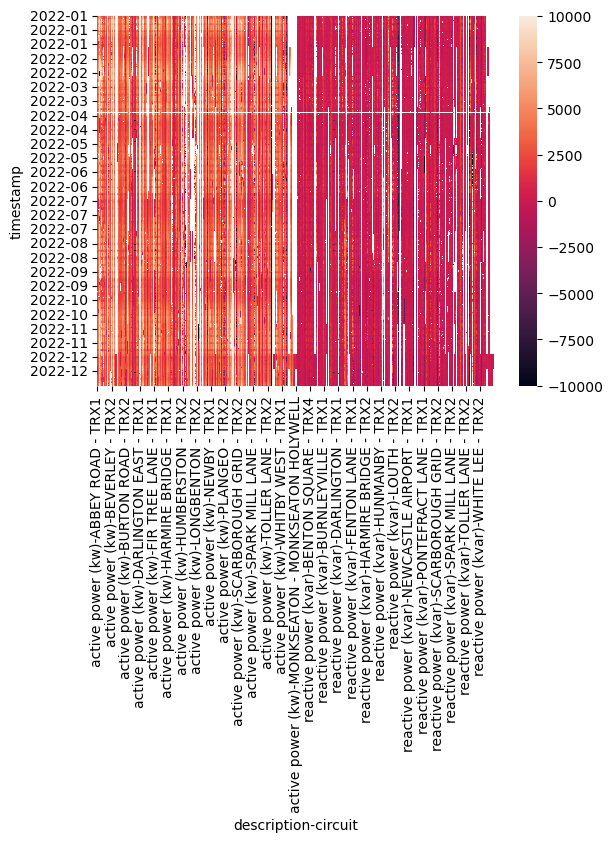

In [ ]:
# | eval: false

d = df.clip(-10000, 10000)
d.index = d.index.strftime("%Y-%m")
sns.heatmap(data=d)
del d


In [ ]:
# | hide
from nbdev.showdoc import *
